<h1> <b> Hungry Guys Radio Track Recommendation Model </b> </h1> <br> <b> The Goal: </b> Train a machine learning model to recommend new songs that fit the vibe of our playlist titled <i> Hungry Guys Radio </i> <br> <b> Data Source: </b> Spotify's API, <i> Spotipy </i> <br> <b> Author: </b> Nik Linnane

<br> <h2> Import Libraries & Data </h2>

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

# data
data = pd.read_csv('/Users/nik.linnane/Downloads/Spotify/mlData.csv')
data['EXPLICIT'] = data['EXPLICIT'].astype(object) # make EXPLICIT categorical

<b> About the Data: </b> This dataset includes the entirety of <i> Hungry Guys Radio </i> as well as various other styled playlists that will allow the model to pick up on patterns. The other playlists include <i> Today's Top Hits, Hot Country, All New Jazz, It's ALT Good </i> (all created by Spotify) and <i> Morgan Freeman </i> (created by Jack).

<br> <h2> Data Inspection </h2>

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ARTIST            641 non-null    object 
 1   ALBUM             641 non-null    object 
 2   TRACK_NAME        641 non-null    object 
 3   DANCEABILITY      641 non-null    float64
 4   ENERGY            641 non-null    float64
 5   LOUDNESS          641 non-null    float64
 6   SPEECHINESS       641 non-null    float64
 7   INSTRUMENTALNESS  641 non-null    float64
 8   LIVENESS          641 non-null    float64
 9   VALENCE           641 non-null    float64
 10  ACOUSTICNESS      641 non-null    float64
 11  EXPLICIT          641 non-null    object 
 12  POPULARITY        641 non-null    int64  
 13  TEMPO             641 non-null    float64
 14  DURATION_MIN      641 non-null    float64
 15  PLAYLIST          641 non-null    object 
 16  HGR               641 non-null    int64  
dt

In [3]:
# check for NULLs
data.isnull().sum().sort_values(ascending=False)

HGR                 0
INSTRUMENTALNESS    0
ALBUM               0
TRACK_NAME          0
DANCEABILITY        0
ENERGY              0
LOUDNESS            0
SPEECHINESS         0
LIVENESS            0
PLAYLIST            0
VALENCE             0
ACOUSTICNESS        0
EXPLICIT            0
POPULARITY          0
TEMPO               0
DURATION_MIN        0
ARTIST              0
dtype: int64

In [4]:
# count of songs per playlist
data.PLAYLIST.value_counts()

Hungry Guys Radio    270
Morgan Freeman       100
It's ALT Good!       100
All New Jazz          71
Today's Top Hits      50
Hot Country           50
Name: PLAYLIST, dtype: int64

In [5]:
# distribution of prediction labels
data.HGR.value_counts()

0    371
1    270
Name: HGR, dtype: int64

<b> Disclaimer: </b> Given there are only 270 tracks on <i> Hungry Guys Radio, </i> the dataset cannot be too large or else the proportion of non-HGR to HGR songs will make the model simply predict most tracks are non-HGR based on pure percentages.

<br> <h2> Data Cleaning </h2>

In [6]:
# remove any duplicate songs within the dataset
    # NOTE we are keeping the first instance to allow all songs within HGR to stay within HGR
data = data.drop_duplicates(subset=['TRACK_NAME'], keep='first')
data.shape

(605, 17)

In [7]:
# dropping unwanted data
data = data.drop(['ALBUM', 'TRACK_NAME', 'PLAYLIST', 'ARTIST'], axis=1) # ARTIST would be useful, but the model needs to handle new artists it hasnt seen before - for our purposes dropping this field is fine

<br> <h2> Data Preprocessing </h2>

In [8]:
# train, test, split using stratified shuffle split
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data,
                                       test_size=0.05, # not a lot of data so only saving 5% for testing
                                       random_state=0, # set state for reproducibility
                                       stratify=data['HGR']) # ensuring equal proportions of HGR tracks within training and testing sets

print('Full Dataset: {:,} \nTraining (95%): {:,} \nTesting (5%): {:,}'.format(len(data), len(train_set), len(test_set)))

Full Dataset: 605 
Training (95%): 574 
Testing (5%): 31


In [9]:
# create training datasets
X_train_pre = train_set.drop(['HGR'], axis=1)
y_train = train_set['HGR'].copy()

# create testing datasets
X_test_pre = test_set.drop(['HGR'], axis=1)
y_test = test_set['HGR'].copy()

In [10]:
# pipeline imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [11]:
# define categorical and numeric features
cat_attribs = ['EXPLICIT'] # categorical features
num_attribs = list(X_train_pre.drop(cat_attribs, axis=1)) # numeric features

# build numeric pipeline
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')), # not used here since there are no NULLs but nice to have just in case new dataing coming in has NULLs
    ('minMax', MinMaxScaler()),
])

# build full pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

In [12]:
# run data through the full pipeline to get our preprocessed training and testing data
X_train = full_pipeline.fit_transform(X_train_pre)
X_test = full_pipeline.fit_transform(X_test_pre)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

X_train:  (574, 13)
X_test:  (31, 13)


<br> <h2> Model Training </h2>

<h3> <font color='black' > 1. Logistic Regression </font> </h3> <blockquote> Commonly used classification algorithm that estimates the probability that an instance belongs to a particular class (in this case HGR). </blockquote>

In [13]:
# import algorithm
from sklearn.linear_model import LogisticRegression

# compile the model
logReg = LogisticRegression(max_iter=1000, random_state=0)

# fit model to training datasets
logReg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

<h4> <font color='black' > Logistic Regression Evaluation </font> </h4>

**Accuracy** <br> <blockquote> <i> NOTE: Accuracy isn't always the best metric for measuring classification models. For example, a model that classifies apples and oranges could be trained on a dataset of 990 oranges and 10 apples. If the model just said everything was an orange, it'd be 99% accurate. This is where confusion matrices, precision, recall and F1 scores come into play! </i> </blockquote>

In [14]:
# score() returns the mean accuracy on the given training data
logRegAccuracy = logReg.score(X_train, y_train)*100
print('Logistic Regression Accuracy: ', logRegAccuracy)

# cross_val_score uses k-fold cross validation to return k accuracy scores. ensures the model didn't get lucky with the initial training set
from sklearn.model_selection import cross_val_score
logRegCVAccuracy = cross_val_score(logReg, X_train, y_train, cv=3, scoring='accuracy')
print('Logistic Regression 3-Fold Cross-Vaidation Accuracy :', logRegCVAccuracy)

Logistic Regression Accuracy:  69.51219512195121
Logistic Regression 3-Fold Cross-Vaidation Accuracy : [0.68229167 0.68586387 0.68586387]


<br> **Confusion Matrix** <br> <blockquote> <i> NOTE: A much better way to evaluate classification models is to look at its confusion matrix. The general idea is to count how many times the model predicted a class correctly and incorrectly using True Positives, True Negatives, False Positives and False Negatives </i> </blockquote>

In [15]:
# cross_val_predict uses k-fold cross validation to return predictions instead of accuracy
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(logReg, X_train, y_train, cv=3)

# printing the confusion matrix from the above training predictions
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[248,  73],
       [108, 145]])

**Interpreting the Confusion Matrix...**
- 248 actually non-HGR tracks that were predicted to be non-HGR (TN)
- 108 actually HGR tracks that were predicted to be non-HGR (FN)
- 73 actually non-HGR tracks that were predicted to be HGR (FP)
- 145 actually HGR tracks that were predicted to be HGR (TP)

<br> **Precision, Recall & F1 Score** <br> <blockquote> <i> NOTE: While the confusion matrix gives a lot of great information, sometimes you may prefer a more concise metric which is when precision, recall and the f1 score become useful. </i> </blockquote>
- Precision: the accuracy of the positive (HGR) predictions
- Recall: the ratio of positive (HGR) instances correctly detected by the classifier
- F1 Score: a harmonic mean of precision and recall. the harmonic mean gives more weight to low values and as a result will only be a high score if both precision and recall are high (ranges 0-1) 

In [16]:
# returns precision and recall scores
from sklearn.metrics import precision_score, recall_score, f1_score
logRegPrecision = precision_score(y_train, y_train_pred)*100
logRegRecall = recall_score(y_train, y_train_pred)*100
logRegF1Score = f1_score(y_train, y_train_pred)
print('Logistic Regression Precision: ', logRegPrecision)
print('Logistic Regression Recall: ', logRegRecall)
print('Logistic Regression F1 Score: ', logRegF1Score)

Logistic Regression Precision:  66.5137614678899
Logistic Regression Recall:  57.31225296442688
Logistic Regression F1 Score:  0.6157112526539278


**Interpreting Precision, Recall & F1 Score...**
- When the model claims a track fits the vibe of HGR, it is correct 66.5% of the time
- The model detects 57.3% of all HGR tracks it sees
- The model has an F1 Score of 0.6 / 1.0

<br> **Adjusting Precision & Recall Using a Desired Threshold** <br> <blockquote> <i> NOTE: Precision and recall have an inverse relationship. One cannot increase without the other decreasing. That being said, we must decide which is more important in our particular use case. An example of when deciding between high precision or high recall is when diagnosing a serious illness. If you want to completely avoid classifying someone as not having an illness when they actually do, you'll favor recall. However, this means you might falsely diagnose someone as having an illness when they actually don't. Still, that's better than the former but would come with an icreased cost of treatment to your hopsital (which is obviously outweighed by not missing anyone who is seriously ill). Alternatively, a model that would favor precision would be classifying banking customers as loan defaulters or not since you wouldn't want to be wrong about assuming that of your customers. </i> </blockquote>
<blockquote> In this use case, I will favor a higher recall because music is so sujective and due to the limited data I have on our playlist, I know this model might not be be as accurate as Spotify's current recommendation algorithm. </blockquote>

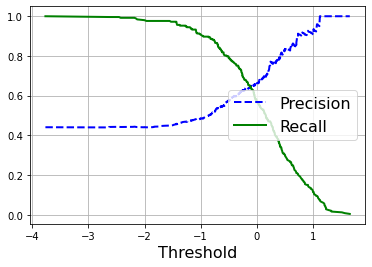

In [17]:
# deciding on the threshold using cross_val_predict
y_scores = cross_val_predict(logReg, X_train, y_train, cv=3, method='decision_function') # we want decision scores instead of predictions

# with these scores we can now plot a precision recall curve
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

# function that uses matplotlib to plot the curve
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel('Threshold', fontsize=16)
    plt.grid(True)
    #plt.axis([-5, 10, 0, 1])

# call function
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

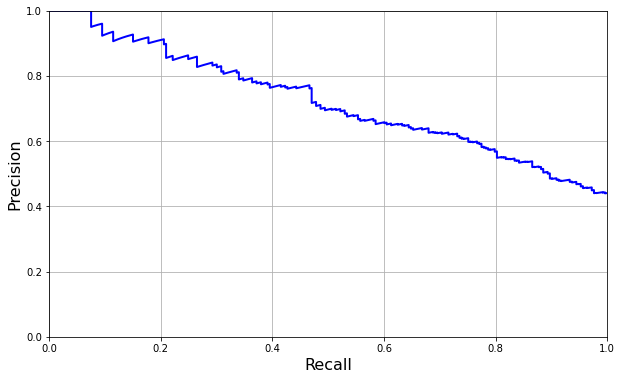

In [18]:
# function to plot precision against recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

# call function
plt.figure(figsize=(10, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

<blockquote> The above plots give us a look into the precision / recall tradoff for this particular model. Looking at the first plot, if I want a recall of 90%, I'll need a threshold of around -0.7 (and a precision of around 0.55). Scikit-Learn doesn't let you adjust the threshold directly, but it does give access to the decision scores of predictions by calling <i> decision_function() </i> as seen above. </blockquote>

In [19]:
# searching for the lowest threshold that gives us 55% precision AKA ~80% recall
recall_55_precision = recalls[np.argmax(precisions >= 0.55)]
threshold_80_recall = thresholds[np.argmax(precisions >= 0.55)] # happens to be -0.59

# making new predictions with our defined threshold of -0.59
y_train_pred_80 = (y_scores >= threshold_80_recall)

# viewing our model's new recall on the training set
recall_score(y_train, y_train_pred_80)*100

81.81818181818183

In [20]:
# new accuracy score with 80% recall
from sklearn.metrics import accuracy_score
round(accuracy_score(y_train, y_train_pred_80, normalize=True), 2)

0.63

In [21]:
# printing the confusion matrix for our new predictions
confusion_matrix(y_train, y_train_pred_80)

array([[152, 169],
       [ 46, 207]])

**Interpreting the New Confusion Matrix...**
- 152 actually non-HGR tracks that were predicted to be non-HGR (TN)
- 46 actually HGR tracks that were predicted to be non-HGR (FN)
- 169 actually non-HGR tracks that were predicted to be HGR (FP)
- 207 actually HGR tracks that were predicted to be HGR (TP)

<blockquote> <i> NOTE: Compared to the previous predictions, here we see a decrease in TN and an increase in TP which is what we'd expect to happen when increasing the recall to 80%. </i> </blockquote> <br>

In [22]:
# returns precision and recall scores for our new predictions
logReg55Precision = precision_score(y_train, y_train_pred_80)*100
logReg80Recall = recall_score(y_train, y_train_pred_80)*100
logReg5580F1Score = f1_score(y_train, y_train_pred_80)
print('Logistic Regression 55% Precision: ', logReg55Precision)
print('Logistic Regression 80% Recall: ', logReg80Recall)
print('Logistic Regression 55/80 F1 Score: ', logReg5580F1Score)

Logistic Regression 55% Precision:  55.053191489361694
Logistic Regression 80% Recall:  81.81818181818183
Logistic Regression 55/80 F1 Score:  0.6581875993640699


**Interpreting New Precision, Recall & F1 Scores...**
- When the model claims a track fits the vibe of HGR, it is correct 55% of the time
- The model detects 81% of all HGR tracks it sees
- The model has an F1 Score of 0.65 / 1.0

<blockquote> <i> NOTE: Compared to the previous predictions, here we see the anticipated precision and recall scores as well as a higher F1 Score than before. </i> </blockquote>

<br> **ROC Curve & AUC** <br> <blockquote> <i> NOTE: The receiver operating characteristic (ROC) curve plots true positive rate (recall) against false positive rate. A great way to compare classifiers is to look at their areas under the curve (AUC). Great classifiers will have an AUC closer to 1 whereas a purely random classifier will have an AUC of 0.5.. </i> </blockquote>

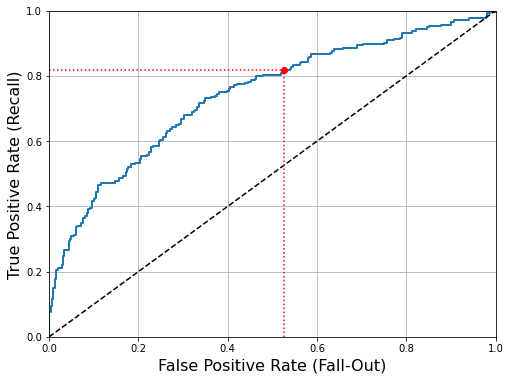

In [23]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

# function to plot roc curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_55 = fpr[np.argmax(tpr >= recall_55_precision)]  
plt.plot([fpr_55, fpr_55], [0., recall_55_precision], 'r:') 
plt.plot([0.0, fpr_55], [recall_55_precision, recall_55_precision], 'r:')
plt.plot([fpr_55], [recall_55_precision], 'ro')
plt.show()

In [24]:
# one way to compare ROC curves is by measuring their AUC (area under the curve)
from sklearn.metrics import roc_auc_score
logRegAUC = roc_auc_score(y_train, y_scores)*100
print('Logistic Regression AUC: ', logRegAUC)

Logistic Regression AUC:  74.12975755113098


**Interpreting the ROC Curve & AUC...**
- The red dot indicates the chosen ration at ~80% recall
- The area between the blue curve and the black diagonal line represents the AUC. In this case it's 74%.

In [25]:
# compile scores for later comparision with other models
logRegSummary = pd.DataFrame({'Model': ['Logistic Regression'],
                               'Accuracy': [round(accuracy_score(y_train, y_train_pred_80, normalize=True), 2)], # accuracy of 80% recall predictions
                               'Mean CV Accuracy': [round(logRegCVAccuracy.mean()*100, 2)], # mean CV accuracy of original model
                               'Precision': [round(logReg55Precision, 2)], # 55% precision
                               'Recall': [round(logReg80Recall, 2)], # 80% recall
                               'F1 Score': [round(logReg5580F1Score, 2)], # f1 score from above precision and recalls
                               'AUC': [round(logRegAUC, 2)],
                               'Split': ['Training']})
logRegSummary

,Model,Accuracy,Mean CV Accuracy,Precision,Recall,F1 Score,AUC,Split
0,Logistic Regression,0.63,68.47,55.05,81.82,0.66,74.13,Training


<br> **Now that we've run through training a model in detail, we can train more models and compare their scores...**

<h3> <font color='black' > 2. Decision Tree Classifier </font> </h3> <blockquote> The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation. </blockquote>

In [26]:
# algorithm imports 
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# compile model
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=0)

# fit model to training data
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

<h4> <font color='black' > Decision Tree Classifier Evaluation </font> </h4>

**Accuracy**

In [27]:
# score() returns the mean accuracy on the given training data
treeClfAccuracy = tree_clf.score(X_train, y_train)*100
print('Decision Tree Classifier Accuracy: ', treeClfAccuracy)

# cross_val_score uses k-fold cross validation to return k accuracy scores. ensures the model didn't get lucky with the initial training set
treeClfCVAccuracy = cross_val_score(tree_clf, X_train, y_train, cv=3, scoring='accuracy')
print('Decision Tree Classifier 3-Fold Cross-Vaidation Accuracy :', treeClfCVAccuracy)

Decision Tree Classifier Accuracy:  70.90592334494772
Decision Tree Classifier 3-Fold Cross-Vaidation Accuracy : [0.64583333 0.67015707 0.61256545]


<br> **Confusion Matrix** <br>

In [28]:
# cross_val_predict uses k-fold cross validation to return predictions instead of accuracy
y_train_pred = cross_val_predict(tree_clf, X_train, y_train, cv=3)

# printing the confusion matrix from the above training predictions
confusion_matrix(y_train, y_train_pred)

array([[210, 111],
       [ 94, 159]])

**Interpreting the Confusion Matrix...**
- 210 actually non-HGR tracks that were predicted to be non-HGR (TN)
- 94 actually HGR tracks that were predicted to be non-HGR (FN)
- 111 actually non-HGR tracks that were predicted to be HGR (FP)
- 159 actually HGR tracks that were predicted to be HGR (TP)

<br>**Precision, Recall & F1 Score**

In [29]:
# returns precision and recall scores
treeClfPrecision = precision_score(y_train, y_train_pred)*100
treeClfRecall = recall_score(y_train, y_train_pred)*100
treeClfF1Score = f1_score(y_train, y_train_pred)
print('Decision Tree Classifier Precision: ', treeClfPrecision)
print('Decision Tree Classifier Recall: ', treeClfRecall)
print('Decision Tree Classifier F1 Score: ', treeClfF1Score)

Decision Tree Classifier Precision:  58.88888888888889
Decision Tree Classifier Recall:  62.845849802371546
Decision Tree Classifier F1 Score:  0.6080305927342257


**Interpreting Precision, Recall & F1 Score...**
- When the model claims a track fits the vibe of HGR, it is correct 59% of the time
- The model detects 63% of all HGR tracks it sees
- The model has an F1 Score of 0.6 / 1.0

<br> **Adjusting Precision & Recall Using a Desired Threshold**

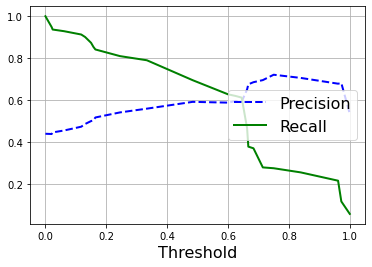

In [30]:
# deciding on the threshold using cross_val_predict
y_scores = cross_val_predict(tree_clf, X_train, y_train, cv=3, method='predict_proba') # decision tree classifier has no decision_function attribute so we'll use predict_proba
y_scores = y_scores[:,1] # predict_proba returns a 2D array of the probability of 0 and then 1. here we're selcting the probability of 1

# with these scores we can now plot a precision recall curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

# call function from earlier to plot curve
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

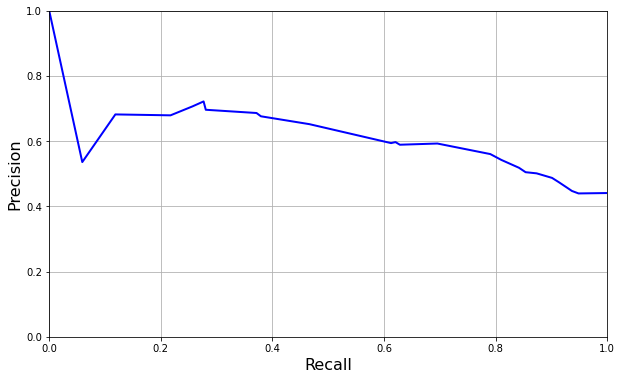

In [31]:
# plot precision against recall using function from earlier
plt.figure(figsize=(10, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [32]:
# again, we want the lowest threshold that gives us ~80% recall, however, it doesnt look like this model can reach that score
recall_55_precision = recalls[np.argmax(precisions >= 0.55)]
threshold_80_recall = thresholds[np.argmax(precisions >= 0.55)] # 0.33

# making new predictions with our defined threshold
y_train_pred_80 = (y_scores >= threshold_80_recall)

# viewing our model's new recall on the training set
recall_score(y_train, y_train_pred_80)*100

79.05138339920948

In [33]:
# new accuracy score with 80% recall
round(accuracy_score(y_train, y_train_pred_80, normalize=True), 2)

0.63

In [34]:
# printing the confusion matrix for our new predictions
confusion_matrix(y_train, y_train_pred_80)

array([[164, 157],
       [ 53, 200]])

**Interpreting the New Confusion Matrix...**
- 164 actually non-HGR tracks that were predicted to be non-HGR (TN)
- 53, actually HGR tracks that were predicted to be non-HGR (FN)
- 157 actually non-HGR tracks that were predicted to be HGR (FP)
- 200 actually HGR tracks that were predicted to be HGR (TP)

In [35]:
# returns precision and recall scores for our new predictions
treeclf55Precision = precision_score(y_train, y_train_pred_80)*100
treeclf80Recall = recall_score(y_train, y_train_pred_80)*100
treeclf5580F1Score = f1_score(y_train, y_train_pred_80)
print('Decision Tree Classifier 55% Precision: ', treeclf55Precision)
print('Decision Tree Classifier 80% Recall: ', treeclf80Recall)
print('Decision Tree Classifier 55/80 F1 Score: ', treeclf5580F1Score)

Decision Tree Classifier 55% Precision:  56.022408963585434
Decision Tree Classifier 80% Recall:  79.05138339920948
Decision Tree Classifier 55/80 F1 Score:  0.6557377049180327


**Interpreting New Precision, Recall & F1 Scores...**
- When the model claims a track fits the vibe of HGR, it is correct 56% of the time
- The model detects 79% of all HGR tracks it sees
- The model has an F1 Score of 0.65 / 1.0

<br> **ROC Curve & AUC**

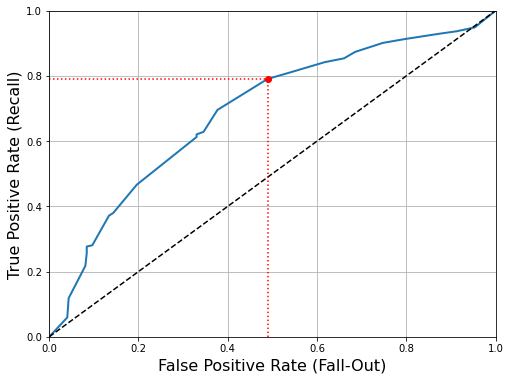

In [36]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_55 = fpr[np.argmax(tpr >= recall_55_precision)]  
plt.plot([fpr_55, fpr_55], [0., recall_55_precision], 'r:') 
plt.plot([0.0, fpr_55], [recall_55_precision, recall_55_precision], 'r:')
plt.plot([fpr_55], [recall_55_precision], 'ro')
plt.show()

In [37]:
# one way to compare ROC curves is by measuring their AUC (area under the curve)
treeClfAUC = roc_auc_score(y_train, y_scores)*100
print('Decision Tree Classifier AUC: ', treeClfAUC)

Decision Tree Classifier AUC:  68.96001871621539


<br> **Visualizing the Decision Tree** <br> <blockquote> <i> NOTE: We can actually visualize the decision tree that the model uses to make predictions with the code below. </i> </blockquote>

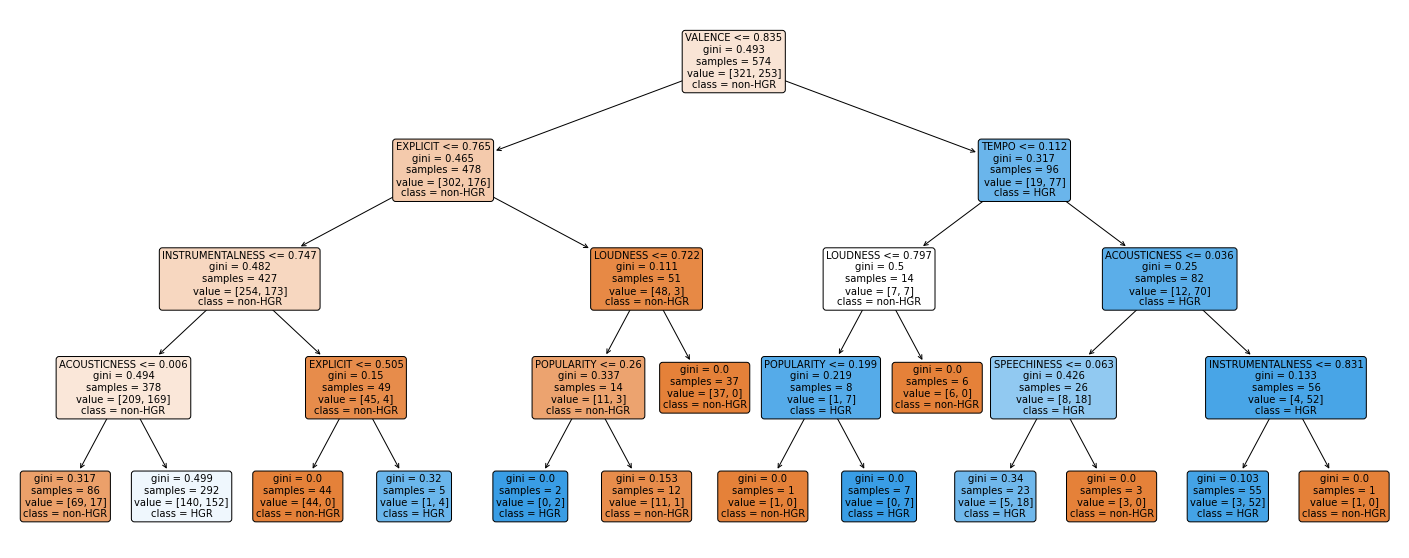

In [38]:
plt.figure(figsize=(25, 10))
plot_tree(tree_clf, 
          #class_names=True,
          class_names=['non-HGR', 'HGR'], # list classes in ascending numerical order
          feature_names=X_train_pre.columns,
          filled=True, 
          rounded=True,
          fontsize=10,
          label='all');

**Interpreting the Decision Tree...**
- Start at the root node and if the condition is met (True) move down and to the left, otherwise, move down and to the right
- Once a leaf node is reached, the tree will give it's prediction on whether it thinks the track is HGR material or not

**Tree Attributes...**
- Gini: Measure of impurity. A node is "pure" (gini = 0) if all training instances it applies to belong to the same class
- Sample: Count of how many training instances fell into that node
- Value: Tells you how many instances of each category ([non-HGR, HGR]) fall into that node

In [39]:
# compile scores for later comparision with other models
treeClfSummary = pd.DataFrame({'Model': ['Decision Tree Classifier'],
                               'Accuracy': [round(accuracy_score(y_train, y_train_pred_80, normalize=True), 2)], # accuracy of 80% recall predictions
                               'Mean CV Accuracy': [round(treeClfCVAccuracy.mean()*100, 2)], # mean CV accuracy of original model
                               'Precision': [round(treeclf55Precision, 2)], # 55% precision
                               'Recall': [round(treeclf80Recall, 2)], # 80% recall (really 79% in the case of this model)
                               'F1 Score': [round(treeclf5580F1Score, 2)], # f1 score from above precision and recalls
                               'AUC': [round(treeClfAUC, 2)],
                               'Split': ['Training']})

modelSummaries = logRegSummary.append(treeClfSummary)

<h3> <font color='black' > 3. K-Nearest Neighbors Classifier </font> </h3> <blockquote> In k-NN classification, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor. </blockquote>

In [40]:
# algorithm imports 
from sklearn.neighbors import KNeighborsClassifier

# compile model
knn_clf = KNeighborsClassifier(n_neighbors=6, 
                               weights='distance', 
                               algorithm='auto', 
                               n_jobs=-1)

# fit model to training data
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=6, weights='distance')

<h4> <font color='black' > KNN Classifier Evaluation </font> </h4>

**Accuracy**

In [41]:
# score returns the mean accuracy on the given training data
knnClfAccuracy = knn_clf.score(X_train, y_train)*100
print('K-Nearest Neighbors Classifier Accuracy: ', knnClfAccuracy)

# cross_val_score uses k-fold cross validation to return k accuracy scores. ensures the model didn't get lucky with the initial training set
knnClfCVAccuracy = cross_val_score(knn_clf, X_train, y_train, cv=3, scoring='accuracy')
print('K-Nearest Neighbors Classifier 3-Fold Cross-Vaidation Accuracy :', knnClfCVAccuracy)

K-Nearest Neighbors Classifier Accuracy:  100.0
K-Nearest Neighbors Classifier 3-Fold Cross-Vaidation Accuracy : [0.625      0.67539267 0.65968586]


<blockquote> NOTE: This is a great example of why to use cross validation since the original accuracy was shown to be 100% which is never a good sign. </blockquote>

<br>**Confusion Matrix**

In [42]:
# cross_val_predict uses k-fold cross validation to return predictions instead of accuracy as we did above
y_train_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

# printing the confusion matrix from the above training predictions
confusion_matrix(y_train, y_train_pred)

array([[236,  85],
       [114, 139]])

**Interpreting the Confusion Matrix...**
- 236 actually non-HGR tracks that were predicted to be non-HGR (TN)
- 114 actually HGR tracks that were predicted to be non-HGR (FN)
- 85 actually non-HGR tracks that were predicted to be HGR (FP)
- 139 actually HGR tracks that were predicted to be HGR (TP)

<br>**Precision, Recall & F1 Score**

In [43]:
# returns precision and recall scores
knnClfPrecision = precision_score(y_train, y_train_pred)*100
knnClfRecall = recall_score(y_train, y_train_pred)*100
knnClfF1Score = f1_score(y_train, y_train_pred)
print('K-Nearest Neighbors Classifier Precision: ', knnClfPrecision)
print('K-Nearest Neighbors Classifier Recall: ', knnClfRecall)
print('K-Nearest Neighbors Classifier F1 Score: ', knnClfF1Score)

K-Nearest Neighbors Classifier Precision:  62.05357142857143
K-Nearest Neighbors Classifier Recall:  54.9407114624506
K-Nearest Neighbors Classifier F1 Score:  0.5828092243186583


**Interpreting Precision, Recall & F1 Score...**
- When the model claims a track fits the vibe of HGR, it is correct 62% of the time
- The model detects 54% of all HGR tracks it sees
- The model has an F1 Score of 0.58 / 1.0

<br> **Adjusting Precision & Recall Using a Desired Threshold**

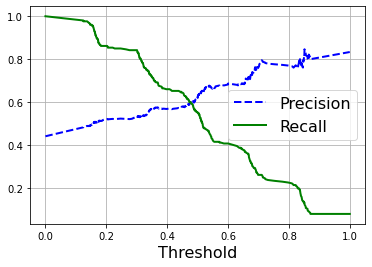

In [44]:
# deciding on the threshold using cross_val_predict
y_scores = cross_val_predict(knn_clf, X_train, y_train, cv=3, method='predict_proba') # knn classifier has no decision_function attribute so we'll use predict_proba
y_scores = y_scores[:,1] # predict_proba returns a 2D array of the probability of 0 and then 1. here we're selcting the probability of 1

# with these scores we can now plot a precision recall curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

# call function from earlier to plot curve
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

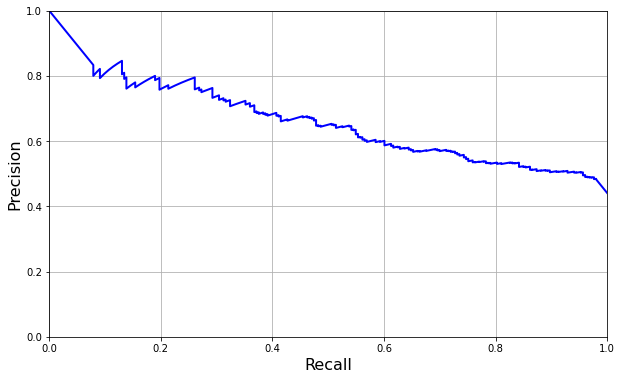

In [45]:
# plot precision against recall using function from earlier
plt.figure(figsize=(10, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [46]:
# again, we want the lowest threshold that gives us ~80% recall, however, it doesnt look like this model can reach that score
recall_55_precision = recalls[np.argmax(precisions >= 0.55)]
threshold_80_recall = thresholds[np.argmax(precisions >= 0.55)] # 0.64

# making new predictions with our defined threshold
y_train_pred_80 = (y_scores >= threshold_80_recall)

# viewing our model's new recall on the training set
recall_score(y_train, y_train_pred_80)*100

74.70355731225297

In [47]:
# new accuracy score with 80% recall
round(accuracy_score(y_train, y_train_pred_80, normalize=True), 2)

0.62

In [48]:
# printing the confusion matrix for our new predictions
confusion_matrix(y_train, y_train_pred_80)

array([[167, 154],
       [ 64, 189]])

**Interpreting the New Confusion Matrix...**
- 167 actually non-HGR tracks that were predicted to be non-HGR (TN)
- 64, actually HGR tracks that were predicted to be non-HGR (FN)
- 154 actually non-HGR tracks that were predicted to be HGR (FP)
- 189 actually HGR tracks that were predicted to be HGR (TP)

In [49]:
# returns precision and recall scores for our new predictions
knnclf55Precision = precision_score(y_train, y_train_pred_80)*100
knnclf80Recall = recall_score(y_train, y_train_pred_80)*100
knnclf5580F1Score = f1_score(y_train, y_train_pred_80)
print('K-Nearest Neighbors Classifier 55% Precision: ', knnclf55Precision)
print('K-Nearest Neighbors Classifier 80% Recall: ', knnclf80Recall)
print('K-Nearest Neighbors Classifier 55/80 F1 Score: ', knnclf5580F1Score)

K-Nearest Neighbors Classifier 55% Precision:  55.10204081632652
K-Nearest Neighbors Classifier 80% Recall:  74.70355731225297
K-Nearest Neighbors Classifier 55/80 F1 Score:  0.634228187919463


**Interpreting Precision, Recall & F1 Score...**
- When the model claims a track fits the vibe of HGR, it is correct 55% of the time
- The model detects 74% of all HGR tracks it sees
- The model has an F1 Score of 0.63 / 1.0

<br>**ROC Curve & AUC**

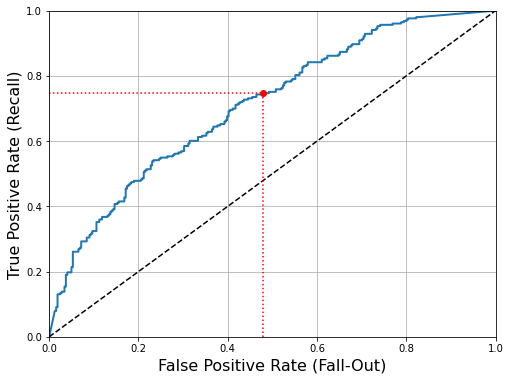

In [50]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_55 = fpr[np.argmax(tpr >= recall_55_precision)]  
plt.plot([fpr_55, fpr_55], [0., recall_55_precision], 'r:') 
plt.plot([0.0, fpr_55], [recall_55_precision, recall_55_precision], 'r:')
plt.plot([fpr_55], [recall_55_precision], 'ro')
plt.show()

In [51]:
# one way to compare ROC curves is by measuring their AUC (area under the curve)
knnClfAUC = roc_auc_score(y_train, y_scores)*100
print('K-Nearest Neighbors Classifier AUC: ', knnClfAUC)

K-Nearest Neighbors Classifier AUC:  70.91167670200585


In [52]:
# compile scores for later comparision with other models
knnClfSummary = pd.DataFrame({'Model': ['K-Nearest Neighbors Classifier'],
                               'Accuracy': [round(accuracy_score(y_train, y_train_pred_80, normalize=True), 2)], # accuracy of 80% recall predictions
                               'Mean CV Accuracy': [round(treeClfCVAccuracy.mean()*100, 2)], # mean CV accuracy of original model
                               'Precision': [round(knnclf55Precision, 2)], # 55% precision
                               'Recall': [round(knnclf80Recall, 2)], # 80% recall (really 74% in the case of this model)
                               'F1 Score': [round(knnclf5580F1Score, 2)], # f1 score from above precision and recalls
                               'AUC': [round(knnClfAUC, 2)],
                               'Split': ['Training']})

modelSummaries = modelSummaries.append(knnClfSummary)
modelSummaries

,Model,Accuracy,Mean CV Accuracy,Precision,Recall,F1 Score,AUC,Split
0,Logistic Regression,0.63,68.47,55.05,81.82,0.66,74.13,Training
0,Decision Tree Classifier,0.63,64.29,56.02,79.05,0.66,68.96,Training
0,K-Nearest Neighbors Classifier,0.62,64.29,55.10,74.70,0.63,70.91,Training


<h3> <font color='black' > 4. Random Forest Classifier with GridSearch CV</font> </h3> <blockquote> 
Random forest classifier creates a set of decision trees from randomly selected subset of training set. It then aggregates the votes from different decision trees to decide the final class of the test object. <br> <br>
    Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. It is an exhaustive search that is performed on a the specific parameter values of a model. The model is also known as an estimator. Grid search exercise can save us time, effort and resources.</blockquote>

In [53]:
# import algorithm and GridSearch CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# hyperparameter tuning dictionary
rf_clf_params = {'n_estimators': [50, 100, 200],
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [3, 5, 7, 10],
                 'n_jobs': [-1],
                 'random_state': [0]}

# compile grid search fit with random forest, hyperparameters and 3-fold cross validation
rf_clf_grid = GridSearchCV(RandomForestClassifier(), rf_clf_params, cv=3, verbose=0)

# fit model to training data
rf_clf_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200], 'n_jobs': [-1],
                         'random_state': [0]})

<h4> <font color='black' > Random Forest GridSearch Classifier Evaluation </font> </h4>

In [54]:
print(f'Best Parameters: {rf_clf_grid.best_params_}')
print(f'Best Parameters Refit Time (seconds): {rf_clf_grid.refit_time_}') # not really needed here but good to know
print(f'Mean Cross-Validated Accuracy Score of best_estimator: ' + \
      f'{rf_clf_grid.best_score_*100:.3f}')

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 0}
Best Parameters Refit Time (seconds): 0.12484097480773926
Mean Cross-Validated Accuracy Score of best_estimator: 74.044


In [55]:
# extract best model from grid search
rf_clf_grid_best = rf_clf_grid.best_estimator_

<br>**Accuracy**

In [56]:
# score returns the mean accuracy on the given training data
rfClfAccuracy = rf_clf_grid_best.score(X_train, y_train)*100
print('Random Forest GridSearch Classifier Accuracy: ', rfClfAccuracy)

# cross_val_score uses k-fold cross validation to return k accuracy scores. ensures the model didn't get lucky with the initial training set
rfClfCVAccuracy = cross_val_score(rf_clf_grid_best, X_train, y_train, cv=3, scoring='accuracy')
print('Random Forest GridSearch  Classifier 3-Fold Cross-Vaidation Accuracy :', rfClfCVAccuracy)

Random Forest GridSearch Classifier Accuracy:  99.65156794425087
Random Forest GridSearch  Classifier 3-Fold Cross-Vaidation Accuracy : [0.72916667 0.72251309 0.76963351]


<br>**Confusion Matrix**

In [57]:
# cross_val_predict uses k-fold cross validation to return predictions instead of accuracy as we did above
y_train_pred = cross_val_predict(rf_clf_grid_best, X_train, y_train, cv=3)

# printing the confusion matrix from the above training predictions
confusion_matrix(y_train, y_train_pred)

array([[258,  63],
       [ 86, 167]])

**Interpreting the Confusion Matrix...**
- 258 actually non-HGR tracks that were predicted to be non-HGR (TN)
- 86 actually HGR tracks that were predicted to be non-HGR (FN)
- 63 actually non-HGR tracks that were predicted to be HGR (FP)
- 167 actually HGR tracks that were predicted to be HGR (TP)

<br>**Precision, Recall & F1 Score**

In [58]:
# returns precision and recall scores
rfClfPrecision = precision_score(y_train, y_train_pred)*100
rfClfRecall = recall_score(y_train, y_train_pred)*100
rfClfF1Score = f1_score(y_train, y_train_pred)
print('Random Forest GridSearch Classifier Precision: ', rfClfPrecision)
print('Random Forest GridSearch Classifier Recall: ', rfClfRecall)
print('Random Forest GridSearch Classifier F1 Score: ', rfClfF1Score)

Random Forest GridSearch Classifier Precision:  72.60869565217392
Random Forest GridSearch Classifier Recall:  66.00790513833992
Random Forest GridSearch Classifier F1 Score:  0.6915113871635611


**Interpreting Precision, Recall & F1 Score...**
- When the model claims a track fits the vibe of HGR, it is correct 72.6% of the time
- The model detects 66% of all HGR tracks it sees
- The model has an F1 Score of 0.69 / 1.0

<br> **Adjusting Precision & Recall Using a Desired Threshold**

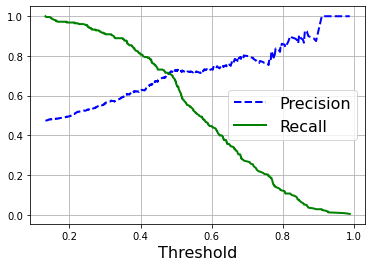

In [59]:
# deciding on the threshold using cross_val_predict
y_scores = cross_val_predict(rf_clf_grid_best, X_train, y_train, cv=3, method='predict_proba') # random forest classifier has no decision_function attribute so we'll use predict_proba
y_scores = y_scores[:,1] # predict_proba returns a 2D array of the probability of 0 and then 1. here we're selcting the probability of 1

# with these scores we can now plot a precision recall curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

# call function from earlier to plot curve
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

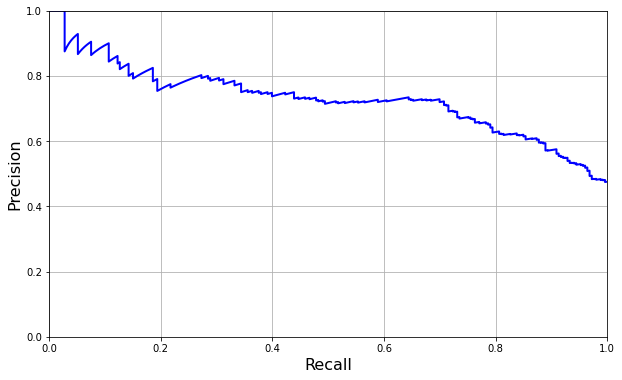

In [60]:
# plot precision against recall using function from earlier
plt.figure(figsize=(10, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [61]:
# again, we want the lowest threshold that gives us ~80% recall
recall_63_precision = recalls[np.argmax(precisions >= 0.63)]
threshold_80_recall = thresholds[np.argmax(precisions >= 0.63)] # 0.41

# making new predictions with our defined threshold
y_train_pred_80 = (y_scores >= threshold_80_recall)

# viewing our model's new recall on the training set
recall_score(y_train, y_train_pred_80)*100

79.44664031620553

In [62]:
# new accuracy score with 80% recall
round(accuracy_score(y_train, y_train_pred_80, normalize=True), 2)

0.7

In [63]:
# printing the confusion matrix for our new predictions
confusion_matrix(y_train, y_train_pred_80)

array([[203, 118],
       [ 52, 201]])

**Interpreting the New Confusion Matrix...**
- 203 actually non-HGR tracks that were predicted to be non-HGR (TN)
- 52, actually HGR tracks that were predicted to be non-HGR (FN)
- 118 actually non-HGR tracks that were predicted to be HGR (FP)
- 201 actually HGR tracks that were predicted to be HGR (TP)

In [64]:
# returns precision and recall scores for our new predictions
rfclf63Precision = precision_score(y_train, y_train_pred_80)*100
rfclf80Recall = recall_score(y_train, y_train_pred_80)*100
rfclf6380F1Score = f1_score(y_train, y_train_pred_80)
print('Random Forest GridSearch Classifier 55% Precision: ', rfclf63Precision)
print('Random Forest GridSearch Classifier 80% Recall: ', rfclf80Recall)
print('Random Forest GridSearch Classifier 63/80 F1 Score: ', rfclf6380F1Score)

Random Forest GridSearch Classifier 55% Precision:  63.00940438871473
Random Forest GridSearch Classifier 80% Recall:  79.44664031620553
Random Forest GridSearch Classifier 63/80 F1 Score:  0.7027972027972027


**Interpreting Precision, Recall & F1 Score...**
- When the model claims a track fits the vibe of HGR, it is correct 63% of the time
- The model detects 79% of all HGR tracks it sees
- The model has an F1 Score of 0.70 / 1.0

<br>**ROC Curve & AUC**

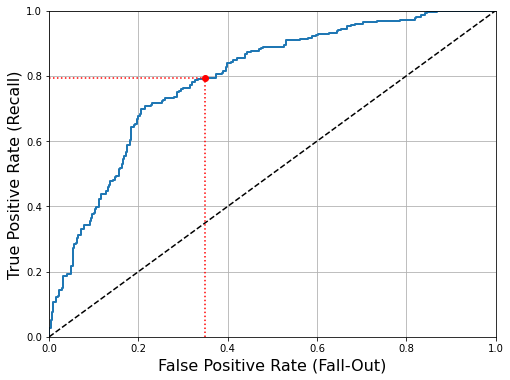

In [65]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_63 = fpr[np.argmax(tpr >= recall_63_precision)]  
plt.plot([fpr_63, fpr_63], [0., recall_63_precision], 'r:') 
plt.plot([0.0, fpr_63], [recall_63_precision, recall_63_precision], 'r:')
plt.plot([fpr_63], [recall_63_precision], 'ro')
plt.show()

In [66]:
# one way to compare ROC curves is by measuring their AUC (area under the curve)
rfClfAUC = roc_auc_score(y_train, y_scores)*100
print('Random Forest GridSearch Classifier AUC: ', rfClfAUC)

Random Forest GridSearch Classifier AUC:  79.26317215224162


In [67]:
# compile scores for later comparision with other models
rfClfSummary = pd.DataFrame({'Model': ['Random Forest GridSearch Classifier'],
                               'Accuracy': [round(accuracy_score(y_train, y_train_pred_80, normalize=True), 2)], # accuracy of 80% recall predictions
                               'Mean CV Accuracy': [round(rfClfCVAccuracy.mean()*100, 2)], # mean CV accuracy of original model
                               'Precision': [round(rfclf63Precision, 2)], # 63% precision
                               'Recall': [round(rfclf80Recall, 2)], # 80% recall (really 79% in the case of this model)
                               'F1 Score': [round(rfclf6380F1Score, 2)], # f1 score from above precision and recalls
                               'AUC': [round(rfClfAUC, 2)],
                               'Split': ['Training']})

modelSummaries = modelSummaries.append(rfClfSummary)
modelSummaries

,Model,Accuracy,Mean CV Accuracy,Precision,Recall,F1 Score,AUC,Split
0,Logistic Regression,0.63,68.47,55.05,81.82,0.66,74.13,Training
0,Decision Tree Classifier,0.63,64.29,56.02,79.05,0.66,68.96,Training
0,K-Nearest Neighbors Classifier,0.62,64.29,55.10,74.70,0.63,70.91,Training
0,Random Forest GridSearch Classifier,0.70,74.04,63.01,79.45,0.70,79.26,Training


<br> <h2> Model Testing </h2> <blockquote> <i> NOTE: We don't necessarily want 100% accuracy or a 1.0 F1 Score - the point of this model is to RECOMMEND songs that we MIGHT want to add to the playlist. The ultimate decision is up to us, but this model will at least give us a narrowed list of tracks we should give a listen. </i> </blockquote>

**Logistic Regression**

In [68]:
# since we cant access the threshold directly, we'll need to retreive the testing y_scores and compare them to the threshold we set during training
y_scores = cross_val_predict(logReg, X_test, y_test, cv=3, method='decision_function') 
threshold = -0.59
y_test_pred = (y_scores > threshold) # compares our predictions to the threshold
y_test_pred_precision = precision_score(y_test, y_test_pred)*100
y_test_pred_recall =recall_score(y_test, y_test_pred)*100
y_test_pred_f1 = f1_score(y_test, y_test_pred)
y_test_pred_AUC = roc_auc_score(y_test, y_scores)*100
y_test_pred_accuracy = logReg.score(X_test, y_test_pred)*100

logRegTestSummary = pd.DataFrame({'Model': ['Logistic Regression'],
                                  'Accuracy': [round(y_test_pred_accuracy, 2)],
                                  'Mean CV Accuracy': ['NA'],
                                  'Precision': [round(y_test_pred_precision, 2)],
                                  'Recall': [round(y_test_pred_recall, 2)],
                                  'F1 Score': [round(y_test_pred_f1, 2)],
                                  'AUC': [round(y_test_pred_AUC, 2)],
                                  'Split': ['Testing']})

<br>**Decision Tree Classifier**

In [69]:
# since we cant access the threshold directly, we'll need to retreive the testing y_scores and compare them to the threshold we set during training
y_scores = cross_val_predict(tree_clf, X_test, y_test, cv=3, method='predict_proba')[:,1] 
threshold = 0.33
y_test_pred = (y_scores > threshold) # compares our predictions to the threshold
y_test_pred_precision = precision_score(y_test, y_test_pred)*100
y_test_pred_recall =recall_score(y_test, y_test_pred)*100
y_test_pred_f1 = f1_score(y_test, y_test_pred)
y_test_pred_AUC = roc_auc_score(y_test, y_scores)*100
y_test_pred_accuracy = logReg.score(X_test, y_test_pred)*100

treeClfTestSummary = pd.DataFrame({'Model': ['Decision Tree Classifier'],
                                  'Accuracy': [round(y_test_pred_accuracy, 2)],
                                  'Mean CV Accuracy': ['NA'],
                                  'Precision': [round(y_test_pred_precision, 2)],
                                  'Recall': [round(y_test_pred_recall, 2)],
                                  'F1 Score': [round(y_test_pred_f1, 2)],
                                  'AUC': [round(y_test_pred_AUC, 2)],
                                  'Split': ['Testing']})
modelTestingSummaries = logRegTestSummary.append(treeClfTestSummary)

<br>**K-Nearest Neighbors Classifier**

In [70]:
# since we cant access the threshold directly, we'll need to retreive the testing y_scores and compare them to the threshold we set during training
y_scores = cross_val_predict(knn_clf, X_test, y_test, cv=3, method='predict_proba')[:,1] 
threshold = 0.64
y_test_pred = (y_scores > threshold) # compares our predictions to the threshold
y_test_pred_precision = precision_score(y_test, y_test_pred)*100
y_test_pred_recall =recall_score(y_test, y_test_pred)*100
y_test_pred_f1 = f1_score(y_test, y_test_pred)
y_test_pred_AUC = roc_auc_score(y_test, y_scores)*100
y_test_pred_accuracy = logReg.score(X_test, y_test_pred)*100

knnClfTestSummary = pd.DataFrame({'Model': ['K-Nearest Neighbors Classifier'],
                                  'Accuracy': [round(y_test_pred_accuracy, 2)],
                                  'Mean CV Accuracy': ['NA'],
                                  'Precision': [round(y_test_pred_precision, 2)],
                                  'Recall': [round(y_test_pred_recall, 2)],
                                  'F1 Score': [round(y_test_pred_f1, 2)],
                                  'AUC': [round(y_test_pred_AUC, 2)],
                                  'Split': ['Testing']})
modelTestingSummaries = modelTestingSummaries.append(knnClfTestSummary)

<br>**Random Forest GridSearch Classifier**

In [71]:
# since we cant access the threshold directly, we'll need to retreive the testing y_scores and compare them to the threshold we set during training
y_scores = cross_val_predict(rf_clf_grid_best, X_test, y_test, cv=3, method='predict_proba')[:,1] 
threshold = 0.41
y_test_pred = (y_scores > threshold) # compares our predictions to the threshold
y_test_pred_precision = precision_score(y_test, y_test_pred)*100
y_test_pred_recall =recall_score(y_test, y_test_pred)*100
y_test_pred_f1 = f1_score(y_test, y_test_pred)
y_test_pred_AUC = roc_auc_score(y_test, y_scores)*100
y_test_pred_accuracy = logReg.score(X_test, y_test_pred)*100

knnClfTestSummary = pd.DataFrame({'Model': ['Random Forest GridSearch Classifier'],
                                  'Accuracy': [round(y_test_pred_accuracy, 2)],
                                  'Mean CV Accuracy': ['NA'],
                                  'Precision': [round(y_test_pred_precision, 2)],
                                  'Recall': [round(y_test_pred_recall, 2)],
                                  'F1 Score': [round(y_test_pred_f1, 2)],
                                  'AUC': [round(y_test_pred_AUC, 2)],
                                  'Split': ['Testing']})
modelTestingSummaries = modelTestingSummaries.append(knnClfTestSummary)

In [72]:
# combine testing results
summaries = pd.concat([modelSummaries, modelTestingSummaries],ignore_index=True)
summaries

,Model,Accuracy,Mean CV Accuracy,Precision,Recall,F1 Score,AUC,Split
0,Logistic Regression,0.63,68.47,55.05,81.82,0.66,74.13,Training
1,Decision Tree Classifier,0.63,64.29,56.02,79.05,0.66,68.96,Training
2,K-Nearest Neighbors Classifier,0.62,64.29,55.10,74.70,0.63,70.91,Training
3,Random Forest GridSearch Classifier,0.70,74.04,63.01,79.45,0.70,79.26,Training
4,Logistic Regression,38.71,NA,46.67,100.00,0.64,35.29,Testing
5,Decision Tree Classifier,51.61,NA,43.75,50.00,0.47,48.53,Testing
6,K-Nearest Neighbors Classifier,38.71,NA,41.67,35.71,0.38,40.34,Testing
7,Random Forest GridSearch Classifier,41.94,NA,34.78,57.14,0.43,36.97,Testing


In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

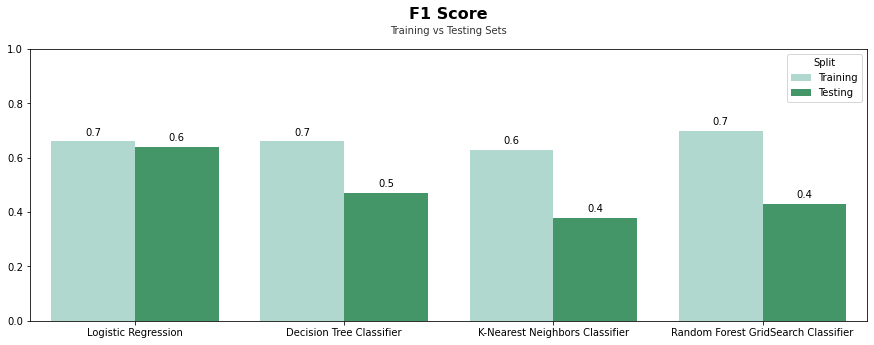

In [74]:
plt.figure(figsize=(15,5))
plot = sns.barplot(data=summaries,
           x='Model',
           y='F1 Score',
           hue='Split',
          palette='BuGn')
plot.set(ylim=(0, 1))
plot.set_xlabel('')
plot.set_ylabel('')
plot.text(x=0.5, y=1.1, s='F1 Score', fontsize=16, weight='bold', ha='center', va='bottom', transform=plot.transAxes)
plot.text(x=0.5, y=1.05, s='Training vs Testing Sets', fontsize=10, alpha=0.80, ha='center', va='bottom', transform=plot.transAxes)
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

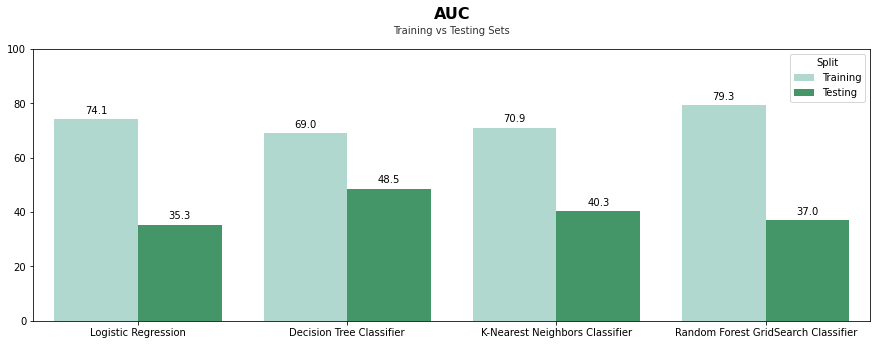

In [75]:
plt.figure(figsize=(15,5))
plot = sns.barplot(data=summaries,
           x='Model',
           y='AUC',
           hue='Split',
          palette='BuGn')
plot.set(ylim=(0, 100))
plot.set_xlabel('')
plot.set_ylabel('')
plot.text(x=0.5, y=1.1, s='AUC', fontsize=16, weight='bold', ha='center', va='bottom', transform=plot.transAxes)
plot.text(x=0.5, y=1.05, s='Training vs Testing Sets', fontsize=10, alpha=0.80, ha='center', va='bottom', transform=plot.transAxes)
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

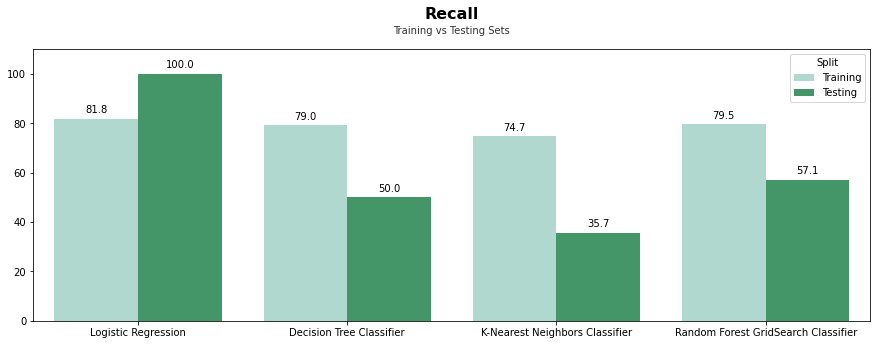

In [76]:
plt.figure(figsize=(15,5))
plot = sns.barplot(data=summaries,
           x='Model',
           y='Recall',
           hue='Split',
          palette='BuGn')
plot.set(ylim=(0, 110))
plot.set_xlabel('')
plot.set_ylabel('')
plot.text(x=0.5, y=1.1, s='Recall', fontsize=16, weight='bold', ha='center', va='bottom', transform=plot.transAxes)
plot.text(x=0.5, y=1.05, s='Training vs Testing Sets', fontsize=10, alpha=0.80, ha='center', va='bottom', transform=plot.transAxes)
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

<br> <h2> Predict On More New Data! </h2>

<blockquote> My friends and I all selected two songs - one we WOULD add to <i> Hungry Guys Radio </i> and another we WOULD NOT. Now we can see if our model agrees :) </blockquote>

In [77]:
# new data
newData = pd.read_csv('/Users/nik.linnane/Downloads/Spotify/testingData.csv')
newData.head(10)

,ARTIST,ALBUM,TRACK_NAME,DANCEABILITY,ENERGY,LOUDNESS,SPEECHINESS,INSTRUMENTALNESS,LIVENESS,VALENCE,ACOUSTICNESS,EXPLICIT,POPULARITY,TEMPO,DURATION_MIN,PLAYLIST,HGR
0,NAV,Emergency Tsunami,Vetement Socks,0.948,0.688,-6.026,0.0756,0.000000,0.0818,0.783,0.08250,1,53,129.946,2.584767,ML Test,0
1,Klingande,Jubel,Jubel,0.698,0.476,-7.459,0.0417,0.238000,0.0542,0.181,0.18500,0,38,124.986,4.727300,ML Test,1
2,Two Door Cinema Club,Tourist History,Something Good Can Work,0.648,0.833,-5.321,0.0327,0.000787,0.1780,0.640,0.00583,0,59,119.935,2.736450,ML Test,1
3,Chelsea Cutler,Sleeping With Roses,The Reason,0.654,0.606,-8.576,0.0717,0.000056,0.3100,0.358,0.09910,1,14,90.058,3.077783,ML Test,0
4,Jack Johnson,Upside Down,Upside Down,0.792,0.647,-8.314,0.0450,0.000223,0.1320,0.694,0.25500,0,70,102.477,3.492450,ML Test,1
5,The War On Drugs,A Deeper Understanding,Thinking of a Place,0.481,0.632,-7.117,0.0333,0.081700,0.1160,0.156,0.38500,0,60,103.323,11.177783,ML Test,0
6,Satin Jackets,Mirage,Mirage,0.680,0.639,-6.150,0.0329,0.009670,0.0809,0.625,0.05850,0,42,106.008,3.231933,ML Test,1
7,Post Malone,Stoney (Deluxe),White Iverson,0.675,0.562,-7.678,0.0352,0.000000,0.0816,0.309,0.23300,1,76,130.098,4.275550,ML Test,0


<br>**Data Proprocessing**

In [78]:
# cleaning
newData['EXPLICIT'] = newData['EXPLICIT'].astype(object)
newData = newData.drop(['ALBUM', 'TRACK_NAME', 'PLAYLIST', 'ARTIST'], axis=1)

# X and y
X_pre = newData.drop(['HGR'], axis=1)
y = newData['HGR']

# pipeline
X = full_pipeline.fit_transform(newData)
print('X: ', X.shape)

X:  (8, 13)


<br>**Predict**

In [79]:
# logistic regression
logReg_y_scores = logReg.predict_proba(X)[:,1] # prediction probability
logReg_threshold = -0.59 # if y_score is higher than this then prediction is True (1)
logReg_y_pred = (logReg_y_scores > logReg_threshold) # compares our predictions to the new threshold

# decision tree classifier
treeClf_y_scores = tree_clf.predict_proba(X)[:,1] # prediction probability
treeClf_threshold = 0.33 # if y_score is higher than this then prediction is True (1)
treeClf_y_pred = (treeClf_y_scores > treeClf_threshold) # compares our predictions to the new threshold

# knn classifier
knnClf_y_scores = knn_clf.predict_proba(X)[:,1] # prediction probability
knnClf_threshold = 0.64 # if y_score is higher than this then prediction is True (1)
knnClf_y_pred = (knnClf_y_scores > knnClf_threshold) # compares our predictions to the new threshold

# random forest gridsearch
rfClf_y_scores = rf_clf_grid_best.predict_proba(X)[:,1] # prediction probability
rfClf_threshold = 0.41 # if y_score is higher than this then prediction is True (1)
rfClf_y_pred = (rfClf_y_scores > rfClf_threshold) # compares our predictions to the new threshold

In [80]:
newDataProb = pd.DataFrame({'Track': ['Vetement Socks', 'Jubel', 'Something Good Can Work', 'The Reason', 'Upside Down', 'Thinking of a Place', 'Mirage', 'White Iverson'],
              'Actual': [y[0], y[1], y[2], y[3], y[4], y[5], y[6], y[7]],
              'Logistic Regression Probability': [logReg_y_scores[0], logReg_y_scores[1], logReg_y_scores[2], logReg_y_scores[3], logReg_y_scores[4], logReg_y_scores[5], logReg_y_scores[6], logReg_y_scores[7]],
              'Decision Tree Probability': [treeClf_y_scores[0], treeClf_y_scores[1], treeClf_y_scores[2], treeClf_y_scores[3], treeClf_y_scores[4], treeClf_y_scores[5], treeClf_y_scores[6], treeClf_y_scores[7]],
              'KNN Probability': [knnClf_y_scores[0], knnClf_y_scores[1], knnClf_y_scores[2], knnClf_y_scores[3], knnClf_y_scores[4], knnClf_y_scores[5], knnClf_y_scores[6], knnClf_y_scores[7]],
              'Random Forest Probability': [rfClf_y_scores[0], rfClf_y_scores[1], rfClf_y_scores[2], rfClf_y_scores[3], rfClf_y_scores[4], rfClf_y_scores[5], rfClf_y_scores[6], rfClf_y_scores[7]]})
newDataProb = newDataProb.round(2)

In [81]:
newDataProb

,Track,Actual,Logistic Regression Probability,Decision Tree Probability,KNN Probability,Random Forest Probability
0,Vetement Socks,0,0.77,1.00,0.71,0.80
1,Jubel,1,0.06,0.00,0.00,0.16
2,Something Good Can Work,1,0.27,0.20,0.33,0.31
3,The Reason,0,0.62,0.52,1.00,0.50
4,Upside Down,1,0.72,1.00,0.84,0.41
5,Thinking of a Place,0,0.18,0.52,0.16,0.20
6,Mirage,1,0.50,0.52,0.66,0.56
7,White Iverson,0,0.16,0.08,0.49,0.18


<br> <h2> Conclusion </h2> <blockquote>

Although these models are not perfect in deciding whether tracks definitively should or shouldn't be added to <i> Hungry Guys Radio, </i> they do predict the probability that a track fits the current playlist vibe which allows us to prioritize listening and make the decision for ourselves. <br> **Potential future project:** what would also be interesting to do with this data would be to train an unsupervised clustering model to get a better understanding of everyones contributions.